In [32]:
import os
from typing import Union

import numpy as np
from onnxruntime import InferenceSession


def get_relative_path(root, *args):
    return os.path.join(os.path.dirname(root), *args)


class EnlightenOnnxModel:
    def __init__(self, model: Union[bytes, str, None] = None):
        self.graph = InferenceSession(model or get_relative_path(__file__, 'enlighten.onnx'))

    def __repr__(self):
        return f'<EnlightenGAN OnnxModel {id(self)}>'

    def _pad(self, img):
        h, w, _ = img.shape
        block_size = 16
        min_height = (h // block_size + 1) * block_size
        min_width = (w // block_size + 1) * block_size
        img = np.pad(img, ((0, min_height - h), (0, min_width - w), (0, 0)),
                     mode='constant', constant_values=0)
        return img, (h, w)

    def _preprocess(self, img):
        if len(img.shape) != 3:
            raise ValueError(f'Incorrect shape: expected 3, got {len(img.shape)}')
        return np.expand_dims(np.transpose(img, (2, 0, 1)).astype(np.float32) / 255., 0)

    def predict(self, img):
        padded, (h, w) = self._pad(img)
        image_numpy, = self.graph.run(['output'], {'input': self._preprocess(padded)})
        image_numpy = (np.transpose(image_numpy[0], (1, 2, 0)) + 1) / 2.0 * 255.0
        image_numpy = np.clip(image_numpy, 0, 255)
        return image_numpy.astype('uint8')[:h, :w, :]

In [33]:
from enlighten_inference import EnlightenOnnxModel
import cv2


In [34]:
img = cv2.imread('/content/low light.jpg')

In [35]:
from google.colab.patches import cv2_imshow

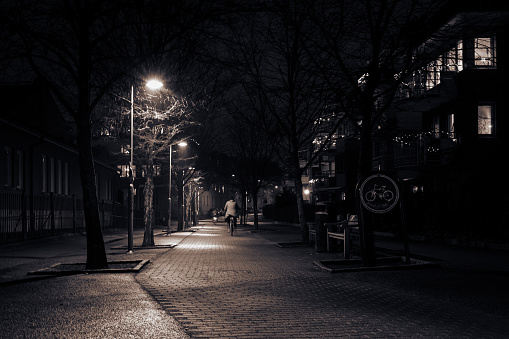

In [36]:
cv2_imshow(img)

In [37]:
model = EnlightenOnnxModel()

In [38]:
processed = model.predict(img)

In [39]:
print(processed)

[[[ 30  29  23]
  [ 53  38  25]
  [ 70  50  31]
  ...
  [  4   3   1]
  [  4   3   1]
  [  8   5   3]]

 [[ 53  39  28]
  [ 53  38  26]
  [ 77  59  41]
  ...
  [  5   2   1]
  [  5   2   0]
  [  4   2   1]]

 [[ 61  42  30]
  [ 74  53  40]
  [ 92  67  52]
  ...
  [ 11   7   7]
  [ 10   6   6]
  [  7   5   7]]

 ...

 [[117 107 106]
  [112 108 104]
  [102  97  82]
  ...
  [125 106  90]
  [116  97  84]
  [113  90  78]]

 [[166 150 140]
  [190 174 164]
  [130 121 113]
  ...
  [133  99  74]
  [133  99  80]
  [123  96  86]]

 [[112 112 109]
  [204 180 166]
  [103  89  91]
  ...
  [120 101  96]
  [126 109 103]
  [146 118 104]]]


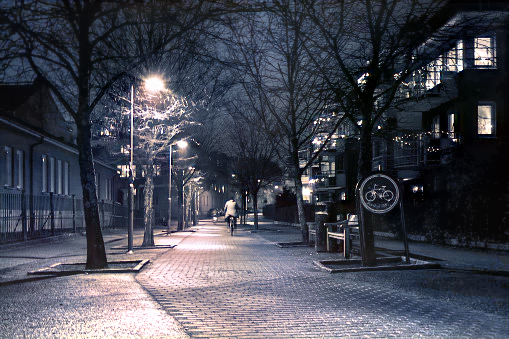

In [40]:
cv2_imshow(processed)